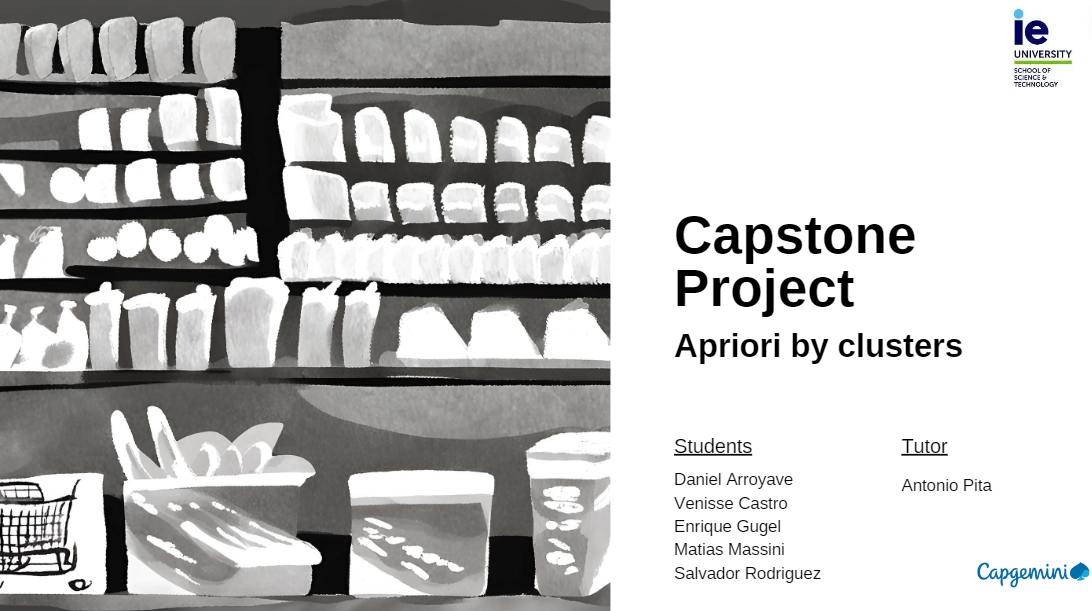

Given a cart, we are going to develop a function to identify the cluster where it belongs and tho give a recommendation based on the apriori algorithm created for the specific cluster

EL YOGUR DE BULGARIA, CORAZONES DE APIO ORGÁNICOS, KIRBY PEPINO, ESPINACA ORGÁNICA DEL BEBÉ, LIMAS, NATURAL ARTESIANO DE AGUA, ORGÁNICA DE HALF & HALF, SIN AZÚCAR ORGÁNICA LECHE DE ALMENDRAS, LIMÓN GRANDE

# **1.   Libraries to be imported**



In [ ]:
import os
from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

import ipywidgets as widgets
from IPython.display import display, HTML


EL YOGUR DE BULGARIA, CORAZONES DE APIO ORGÁNICOS, KIRBY PEPINO, ESPINACA ORGÁNICA DEL BEBÉ, LIMAs, NATURAL ARTESIANO DE AGUA, ORGÁNICA DE HALF & HALF, SIN AZÚCAR ORGÁNICA LECHE DE ALMENDRAS, LIMÓN GRANDE

In [ ]:
# Cart examples
example_1 = ['ESPINACA ORGÁNICA DEL BEBÉ', 'AGUACATE ORGÁNICO', 'CEBOLLA AMARILLA ORGÁNICA']
example_2 = ['FRESAS ORGÁNICAS']
example_3 = ['FRESAS ORGÁNICAS', 'ORGÁNICA EXTRA GRANDE FANTASÍA MANZANA FUJI']
example_4 = ['EL YOGUR DE BULGARIA', 'FRESAS ORGÁNICAS', 'ORGÁNICA EXTRA GRANDE FANTASÍA MANZANA FUJI', 'ESPINACA ORGÁNICA DEL BEBÉ', 'AGUACATE ORGÁNICO', 'CEBOLLA AMARILLA ORGÁNICA', 'ORGÁNICA DE HALF & HALF', 'SIN AZÚCAR ORGÁNICA LECHE DE ALMENDRAS', 'KIRBY PEPINO']
example_5 = ['EL YOGUR DE BULGARIA', 'CORAZONES DE APIO ORGÁNICOS', 'KIRBY PEPINO', 'ESPINACA ORGÁNICA DEL BEBÉ', 'LIMAS', 'NATURAL ARTESIANO DE AGUA', 'ORGÁNICA DE HALF & HALF', 'SIN AZÚCAR ORGÁNICA LECHE DE ALMENDRAS', 'LIMÓN GRANDE']

In [ ]:
# Function to load the data and model for clustering
def load_data_and_model_for_clustering(data_path, model_path1, model_path2):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(data_path)

    # Extract product info
    pruduct_info = df[['id_producto', 'nombre_producto', 'id_pasillo', 'id_departamento', 'pasillo', 'departamento']]
    pruduct_info = pruduct_info.drop_duplicates(subset=['id_producto'])
    pruduct_info = pruduct_info.set_index('id_producto')

    # Load model and feature names
    clf = joblib.load(model_path1)
    feature_names = joblib.load(model_path2)

    return pruduct_info, clf, feature_names

# Function to create filtered product DataFrame
def create_filtered_product_dataframe(pruduct_info, product_list, feature_names):
    filtered_df = pruduct_info[pruduct_info['nombre_producto'].isin(product_list)]

    # Count the number of products by aisle
    df_counts = filtered_df.groupby('pasillo').size().reset_index(name='counts')

    # Create the DataFrame with the desired structure
    aisles = pruduct_info['pasillo'].unique()
    data = {f'department_{aisle}': [0] for aisle in aisles}

    # Fill the data
    for _, row in df_counts.iterrows():
        data[f'department_{row["pasillo"]}'] = [row['counts']]

    # Convert the dictionary to DataFrame
    df_final = pd.DataFrame(data)
    df_final = df_final[feature_names]

    return df_final

# Function to predict the cluster
def predict_cluster(data_path, model_path1, model_path2, product_list):
    # Load data and model
    pruduct_info, clf, feature_names = load_data_and_model_for_clustering(data_path, model_path1, model_path2)

    # Create filtered product DataFrame
    sale = create_filtered_product_dataframe(pruduct_info, product_list, feature_names)
    print("Filtered product dataframe:\n", sale)  # Debug print

    # Make predictions
    predictions = clf.predict(sale)
    print("Predictions:", predictions)  # Debug print

    return predictions

# Function to load Apriori rules based on the cluster
def load_apriori_rules(cluster, base_path):
    file_path = f'{base_path}/df_apriori_rules_cluster_{cluster}.csv'
    rules_df = pd.read_csv(file_path)
    rules_df['antecedents'] = rules_df['antecedents'].apply(eval)
    rules_df['consequents'] = rules_df['consequents'].apply(eval)
    return rules_df

# Recommender class to handle recommendations based on Apriori rules
class AprioriRecommender:
    def __init__(self, rules_df):
        self.rules_df = rules_df

    def get_recommendations(self, items):
        recommendations = []
        for _, row in self.rules_df.iterrows():
            if set(items).issubset(set(row['antecedents'])):
                recommendations.extend(row['consequents'])
        return list(set(recommendations))

# Initialize the Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the paths
data_path = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/df_final_version.csv'
model_path1 = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/Cluster_models/random_forest_model.joblib'
model_path2 = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/Cluster_models/feature_names.joblib'
rules_base_path = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/Apriori_rules/4_cluster'

# Select the example to use
product_list = example_3

# Predict the cluster for the given product list
predictions = predict_cluster(data_path, model_path1, model_path2, product_list)
cluster = predictions[0]
print("Identified cluster:", cluster)  # Debug print

# Load the appropriate Apriori rules for the predicted cluster
rules_df = load_apriori_rules(cluster, rules_base_path)

# Initialize the recommender with the loaded rules
recommender = AprioriRecommender(rules_df)

# Create widgets for user input and output
item_input = widgets.Text(
    value='',
    placeholder='Enter items separated by commas',
    description='Items:',
    disabled=False
)

output = widgets.Output()

recommend_button = widgets.Button(
    description='Recommend',
    disabled=False,
    button_style='',
    tooltip='Click to get recommendations',
    icon='check'
)

# Define the function to get recommendations
def recommend_items(b):
    items = [item.strip().upper() for item in item_input.value.split(',')]
    recommendations = recommender.get_recommendations(items)
    with output:
        output.clear_output()
        print(f"Cluster: {cluster}")
        print(f"Recommendations for items {items}: {recommendations}")

recommend_button.on_click(recommend_items)

# Display the widgets
display(HTML("<style>.widget-label { min-width: 20ex !important; }</style>"))
display(item_input)
display(recommend_button)
display(output)

# Toggle code visibility
display(HTML("""
<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
  }
  $( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>
"""))


Mounted at /content/drive
Filtered product dataframe:
    department_ACEITES VINAGRES  department_ENVASADOS ​​DE FRUTAS Y VEGETALES  \
0                            0                                             0   

   department_FRUTA SEMILLAS FRUTOS SECOS  department_HIERBAS FRESCAS  \
0                                       0                           0   

   department_PRODUCTOS CONGELADOS  department_VEGETALES FRESCOS  \
0                                0                             0   

   department_BEBIDAS VEGETALES Y SIN LACTOSA  department_FRUTAS FRESCAS  \
0                                           0                          2   

   department_GALLETAS  department_POSTRES REFRIGERADOS PUDÍN  ...  \
0                    0                                      0  ...   

   department_MEZCLAS DE BEBIDAS DE CACAO  department_BEBIDAS ESPIRITUOSAS  \
0                                       0                                0   

   department_GRANOS A GRANEL  department_ALIMENT

Text(value='', description='Items:', placeholder='Enter items separated by commas')

Button(description='Recommend', icon='check', style=ButtonStyle(), tooltip='Click to get recommendations')

Output()